In [ ]:
# THE CONSUMER PRICE INDEX (CPI) IS A MEASURE OF THE AVERAGE CHANGE OVER TIME IN THE PRICES PAID BY URBAN CONSUMERS FOR A MARKET BASKET OF CONSUMER GOODS AND SERVICES.
# IN THIS CPI SERIES INDEX WE ARE LOOKING AT ELECTRICITY PRICES OVER THE PAST 10 YEAR PERIOD - INCREASE CPI = INFLATION = RISING COST OF LIVING
# TIME SERIES FORECASTING WITH ARIMA MODELING IS STATISTICAL AND PREDICTIVE ANALYTICAL APPROACH OF SEEING THE FUTURE BASED ON HISTORICAL DATA

In [1]:
#ALL THE PACKAGES I HAVE CAME ACROSS WHICH CAN DO MANY DIFFERET WAYS OF VIZUALIZATION IN PYTHON

import requests
import json
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# SECTION OF CODE WHERE I CONNECT TO THE BLS.GOV API FOR CPI DATA
BLS_API_KEY = 'f25896f3a6d24c739dff89912a87b169'

headers = {'Content-type': 'application/json'}
data = {
    "seriesid": ["CUUR0000SEHF01"],
    "startyear": "2014",
    "endyear": "2025",
    "registrationkey": BLS_API_KEY
}


response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', json=data, headers=headers)
json_data = response.json()

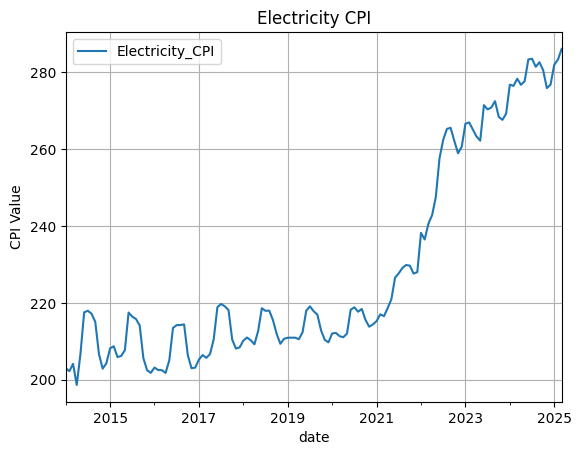

In [3]:
# THERE ARE MULTIPLE WAYS OF SAVING THE VARIOUS FIELDS FROM THE API. A SIMPLE LINE CHART OF ELECTRICAL CPI.

series_data = json_data['Results']['series'][0]['data']
df = pd.DataFrame(series_data)
df['value'] = df['value'].astype(float)
df['date'] = pd.to_datetime(df['year'] + '-' + df['period'].str[1:] + '-01')
df = df[['date', 'value']].sort_values('date').reset_index(drop=True)
df.set_index('date', inplace=True)
df.rename(columns={'value': 'Electricity_CPI'}, inplace=True)

# Plot
df.plot(title='Electricity CPI')
plt.ylabel('CPI Value')
plt.grid(True)
plt.show()

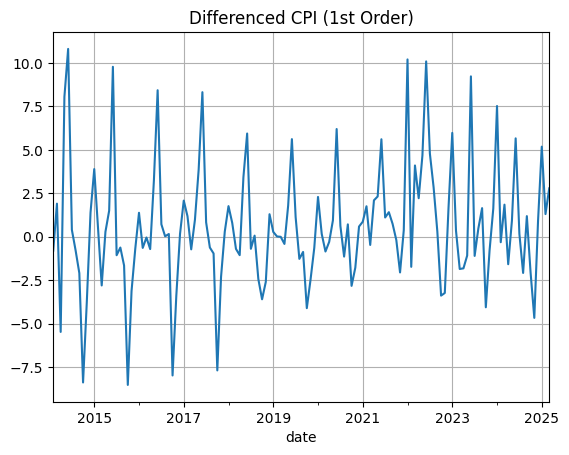

In [4]:
# THE FIRST DIFFERENCING - WHAT I AM LOOKING FOR IS A FLAT MEAN AND VARIANCE OVER TIME. NO CLEAR TRENDS OR SEASONALITY.
# No Trend: The data fluctuates around a relatively constant mean.
# Constant Variance: The ups and downs should be roughly the same size over time.
# Random Noise Appearance: It looks more like a flat, unpredictable series — no obvious patterns.
# ADF Test p-value < 0.05: Statistically confirms stationarity.
# IF FINANCIAL DATA, RULE OF THUMB IS THAT THE DATA ALWAYS NEEDS TO BE DIFFERENCED AT LEAST ONCE. CPI IS THAT.

ts = df['Electricity_CPI']
ts_diff = ts.diff().dropna()

ts_diff.plot(title='Differenced CPI (1st Order)')
plt.grid(True)
plt.show()

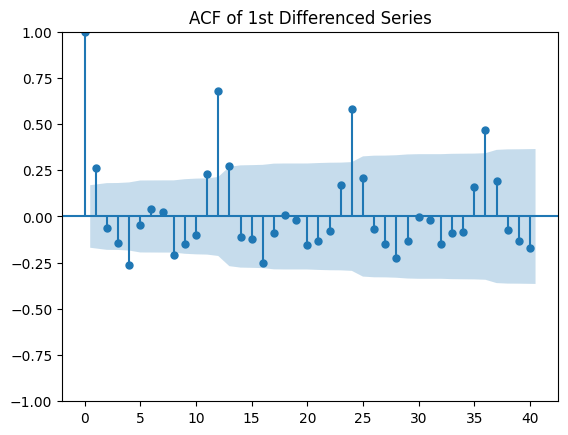

In [5]:
#ACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_acf(ts_diff, lags=40)
plt.title("ACF of 1st Differenced Series")
plt.show()

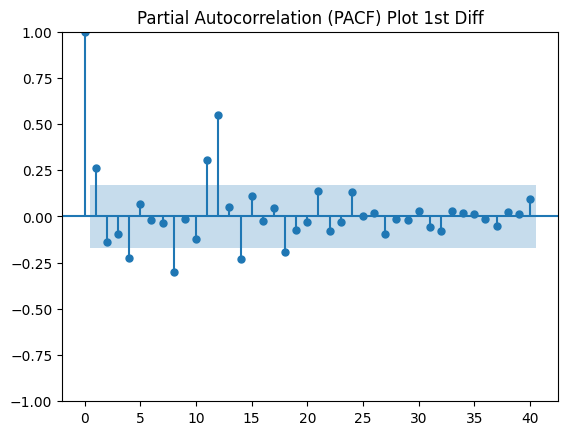

In [6]:
# PACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_pacf(ts_diff, lags=40, method='ywm')
plt.title("Partial Autocorrelation (PACF) Plot 1st Diff")
plt.show()

In [7]:
# ADF TEST OUTPUT
# P-VALUE >0.05 - FAIL TO REJECT NULL -> TIME SERIES IS NON STATIONARY
# P-VALUE <= 0.05 - REJECT NULL -> TIME SERIES IS STATIONARY

result = adfuller(ts_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.887305980154203
p-value: 0.338056139297086


In [8]:
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

In [9]:
forecast_1_result = model_fit.get_forecast(steps=12)
forecast_1 = forecast_1_result.predicted_mean
conf_int = forecast_1_result.conf_int()
residuals = model_fit.resid

In [ ]:
# Ljung-Box Q Test
# A p-value greater than 0.05 (or 5%) suggests the residuals are random and independent, indicating the model is a good fit

In [10]:
# Perform Ljung-Box test (default lag is 10)
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  0.948862   0.999865


In [ ]:
# lb_pvalue -> P-value → the most important part
# If p-value > 0.05 → residuals do NOT show autocorrelation → model looks good!
# If p-value < 0.05 → residuals still have autocorrelation → model may be missing something.

In [11]:
ljung_box_results = acorr_ljungbox(residuals, lags=range(1, 21), return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
1   0.002515   0.960001
2   0.014588   0.992733
3   0.214554   0.975206
4   0.418596   0.980926
5   0.552801   0.990062
6   0.553856   0.997120
7   0.561953   0.999187
8   0.601099   0.999732
9   0.923306   0.999595
10  0.948862   0.999865
11  0.951931   0.999961
12  1.169451   0.999966
13  1.169568   0.999990
14  1.200740   0.999997
15  1.206323   0.999999
16  1.207916   1.000000
17  1.443180   1.000000
18  1.504779   1.000000
19  1.509137   1.000000
20  1.617562   1.000000


In [12]:
last_date = ts.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_1.index = forecast_index
conf_int.index = forecast_index

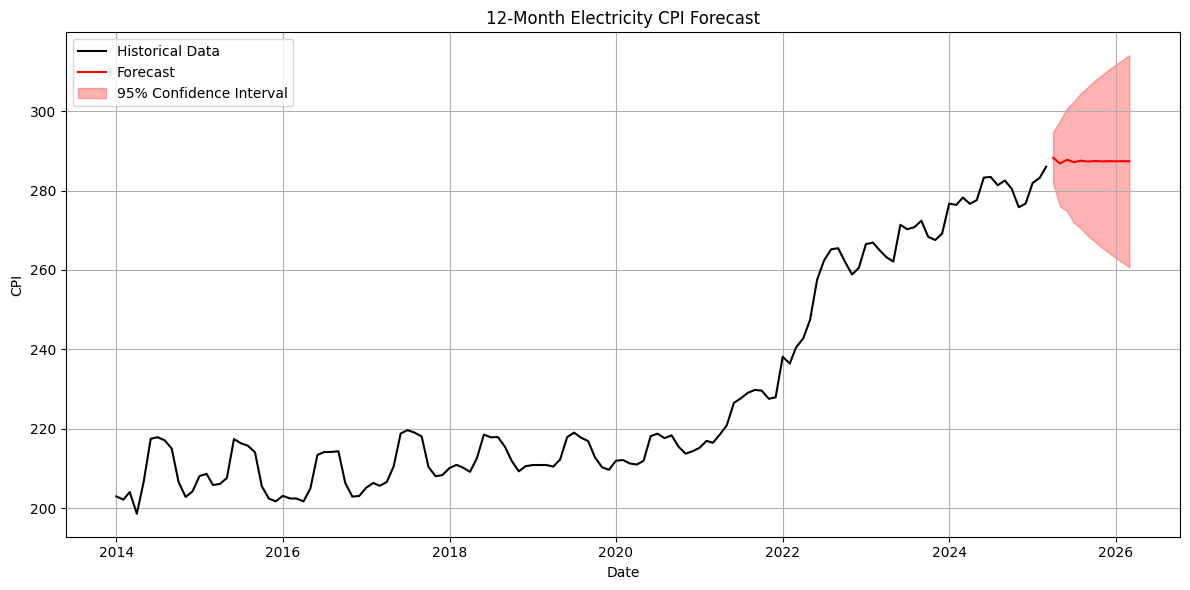

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data', color='black')
plt.plot(forecast_1, label='Forecast', color='red')
plt.fill_between(forecast_1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('12-Month Electricity CPI Forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
print("Forecast with 1st Differencing:")
print(forecast_1)

Forecast with 1st Differencing:
2025-04-01    288.259817
2025-05-01    286.794377
2025-06-01    287.737586
2025-07-01    287.130503
2025-08-01    287.521243
2025-09-01    287.269749
2025-10-01    287.431620
2025-11-01    287.327434
2025-12-01    287.394492
2026-01-01    287.351331
2026-02-01    287.379111
2026-03-01    287.361231
Freq: MS, Name: predicted_mean, dtype: float64


In [15]:
forecast_df = pd.DataFrame({
    'Forecast': forecast_1,
    'Lower CI (95%)': conf_int.iloc[:, 0],
    'Upper CI (95%)': conf_int.iloc[:, 1]
})



In [16]:
print(forecast_df)

              Forecast  Lower CI (95%)  Upper CI (95%)
2025-04-01  288.259817      281.749880      294.769754
2025-05-01  286.794377      276.051846      297.536908
2025-06-01  287.737586      274.785704      300.689468
2025-07-01  287.130503      271.865739      302.395267
2025-08-01  287.521243      270.497708      304.544779
2025-09-01  287.269749      268.508749      306.030749
2025-10-01  287.431620      267.167008      307.696232
2025-11-01  287.327434      265.611731      309.043138
2025-12-01  287.394492      264.350103      310.438880
2026-01-01  287.351331      263.031707      311.670955
2026-02-01  287.379111      261.859586      312.898636
2026-03-01  287.361231      260.688531      314.033930


In [ ]:
# MY CONCLUSION AFTER DOING THE FIRST DIFFERENCING. DURING THE ADF TEST THE P-VALUE WAS OVER 0.05,
# THEREFORE THE DATASET IS STILL NON-STATIONARY.

In [ ]:
# BELOW IS THE 2ND DIFFERENCING AND THE RESULTS

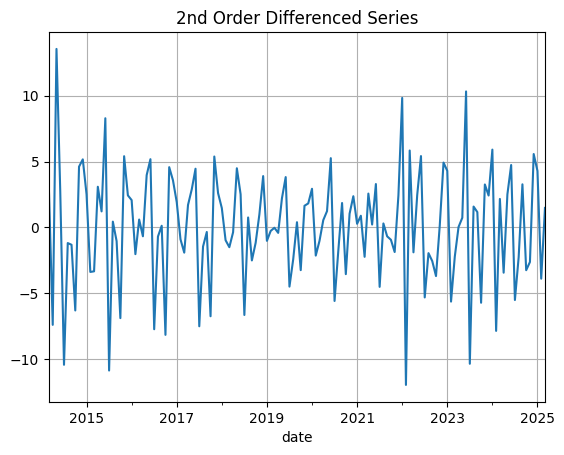

In [17]:
ts2 = df['Electricity_CPI']
ts_diff2 = ts_diff.diff().dropna()

ts_diff2.plot(title="2nd Order Differenced Series")
plt.grid(True)
plt.show()


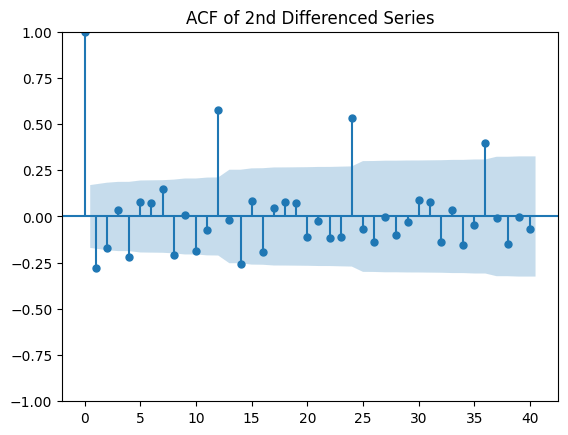

In [18]:
plot_acf(ts_diff2, lags=40)
plt.title("ACF of 2nd Differenced Series")
plt.show()

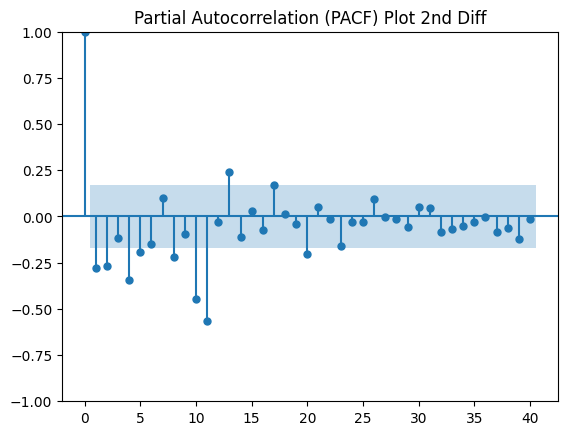

In [19]:
# PACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_pacf(ts_diff2, lags=40, method='ywm')
plt.title("Partial Autocorrelation (PACF) Plot 2nd Diff")
plt.show()

In [20]:
# ADF TEST OUTPUT
# P-VALUE >0.05 - FAIL TO REJECT NULL -> TIME SERIES IS NON STATIONARY
# P-VALUE <= 0.05 - REJECT NULL -> TIME SERIES IS STATIONARY

result = adfuller(ts_diff2)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.449567944972001
p-value: 0.00024228628713145913


In [21]:
model = ARIMA(ts2, order=(1, 1, 1))
model_fit = model.fit()

In [22]:
forecast_2_result = model_fit.get_forecast(steps=12)
forecast_2 = forecast_2_result.predicted_mean
conf_int_2 = forecast_2_result.conf_int()
residuals_2 = model_fit.resid

In [ ]:
# Ljung-Box Q Test
# A p-value greater than 0.05 (or 5%) suggests the residuals are random and independent, indicating the model is a good fit

In [23]:
# Perform Ljung-Box test (default lag is 10)
ljung_box_results = acorr_ljungbox(residuals_2, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  0.948862   0.999865


In [ ]:
# lb_pvalue -> P-value → the most important part
# If p-value > 0.05 → residuals do NOT show autocorrelation → model looks good!
# If p-value < 0.05 → residuals still have autocorrelation → model may be missing something.

In [24]:
ljung_box_results = acorr_ljungbox(residuals_2, lags=range(1, 21), return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
1   0.002515   0.960001
2   0.014588   0.992733
3   0.214554   0.975206
4   0.418596   0.980926
5   0.552801   0.990062
6   0.553856   0.997120
7   0.561953   0.999187
8   0.601099   0.999732
9   0.923306   0.999595
10  0.948862   0.999865
11  0.951931   0.999961
12  1.169451   0.999966
13  1.169568   0.999990
14  1.200740   0.999997
15  1.206323   0.999999
16  1.207916   1.000000
17  1.443180   1.000000
18  1.504779   1.000000
19  1.509137   1.000000
20  1.617562   1.000000


In [25]:
last_date_V2 = ts2.index[-1]
forecast_index_2 = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_2.index = forecast_index_2
conf_int_2.index_2 = forecast_index_2

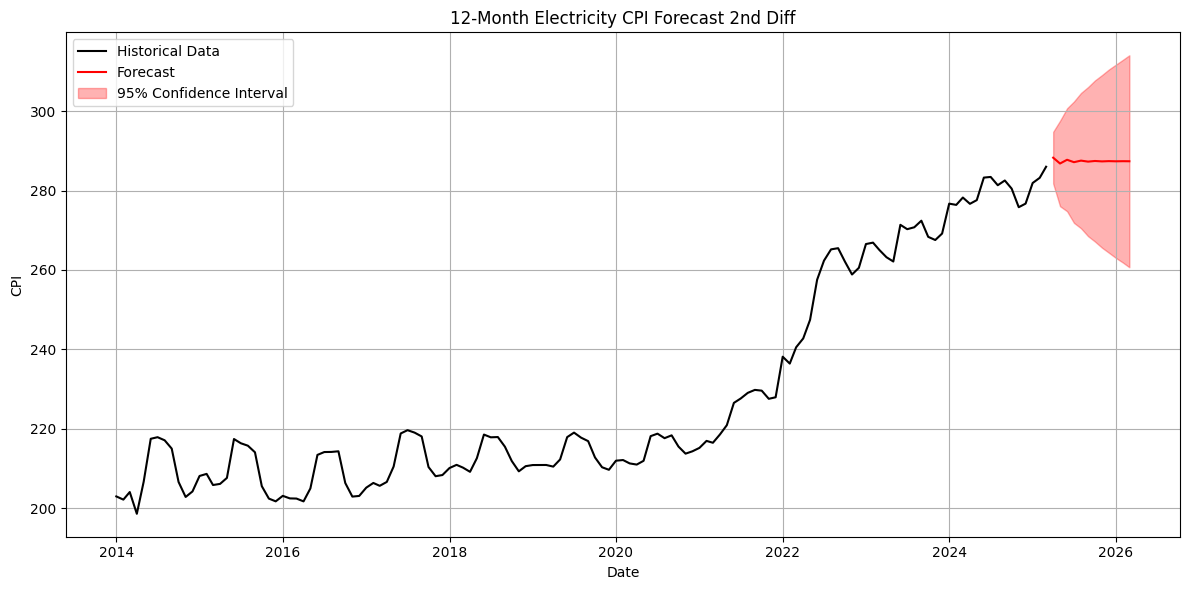

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data', color='black')
plt.plot(forecast_2, label='Forecast', color='red')
plt.fill_between(forecast_2.index, conf_int_2.iloc[:, 0], conf_int_2.iloc[:, 1],
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('12-Month Electricity CPI Forecast 2nd Diff')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
print("Forecast with 2ND Differencing:")
print(forecast_2)

Forecast with 2ND Differencing:
2025-04-01    288.259817
2025-05-01    286.794377
2025-06-01    287.737586
2025-07-01    287.130503
2025-08-01    287.521243
2025-09-01    287.269749
2025-10-01    287.431620
2025-11-01    287.327434
2025-12-01    287.394492
2026-01-01    287.351331
2026-02-01    287.379111
2026-03-01    287.361231
Freq: MS, Name: predicted_mean, dtype: float64


In [28]:
forecast_2_df = pd.DataFrame({
    'Forecast': forecast_2,
    'Lower CI (95%)': conf_int_2.iloc[:, 0],
    'Upper CI (95%)': conf_int_2.iloc[:, 1]
})

In [29]:
print(forecast_2_df)

              Forecast  Lower CI (95%)  Upper CI (95%)
2025-04-01  288.259817      281.749880      294.769754
2025-05-01  286.794377      276.051846      297.536908
2025-06-01  287.737586      274.785704      300.689468
2025-07-01  287.130503      271.865739      302.395267
2025-08-01  287.521243      270.497708      304.544779
2025-09-01  287.269749      268.508749      306.030749
2025-10-01  287.431620      267.167008      307.696232
2025-11-01  287.327434      265.611731      309.043138
2025-12-01  287.394492      264.350103      310.438880
2026-01-01  287.351331      263.031707      311.670955
2026-02-01  287.379111      261.859586      312.898636
2026-03-01  287.361231      260.688531      314.033930


In [ ]:
# ABOVE ARE MY FINAL RESULTS